## Clonamos el repositorio dentro del notebook

In [22]:
import os

repo_url = "https://github.com/AgusMattiussi/sleep-linear.git"
repo_name = "sleep-linear"

if not os.path.isdir(repo_name):
    !git clone {repo_url}
else:
    print(f"La carpeta '{repo_name}' ya existe. No se clona el repositorio.")

%cd {repo_name}

Cloning into 'sleep-linear'...
remote: Enumerating objects: 124, done.
remote: Counting objects: 100% (42/42), done.
remote: Compressing objects: 100% (23/23), done.
remote: Total 124 (delta 29), reused 28 (delta 19), pack-reused 82
Receiving objects: 100% (124/124), 13.38 MiB | 15.14 MiB/s, done.
Resolving deltas: 100% (54/54), done.
/content/sleep-linear/sleep-linear


## Dependencias

In [ ]:
!pip install -r requirements.txt

In [3]:
import os
import sys
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly_resampler import FigureResampler
from tqdm.auto import tqdm
from google.colab import drive

In [4]:
%cd src
from data import load_signals, load_annotations, annotation_to_30s_labels
%cd ..

/content/sleep-linear/src
/content/sleep-linear


## Carga de datos desde Drive

In [ ]:
def mount_drive():
    drive.mount('/content/drive')

def unmount_drive():
    drive.flush_and_unmount()

def copy_folder(src, dest):
    try:
        mount_drive()

        if not os.path.exists(dest):
            shutil.copytree(src, dest)
            print(f'Carpeta copiada exitosamente de {src} a {dest}.')
        else:
            for root, dirs, files in os.walk(src):
                for dir in dirs:
                    dest_dir = os.path.join(dest, os.path.relpath(os.path.join(root, dir), src))
                    if not os.path.exists(dest_dir):
                        os.makedirs(dest_dir)

                for file in files:
                    src_file = os.path.join(root, file)
                    dest_file = os.path.join(dest, os.path.relpath(src_file, src))
                    if not os.path.exists(dest_file):
                        shutil.copy2(src_file, dest_file)
                        print(f'Archivo copiado: {src_file} a {dest_file}')
            print(f'Archivos faltantes copiados exitosamente de {src} a {dest}.')

    except Exception as e:
        print(f'Ocurrió un error: {e}')
        unmount_drive()
        print('Desmontando y volviendo a montar Google Drive...')
        mount_drive()

        try:
            if not os.path.exists(dest):
                shutil.copytree(src, dest)
                print(f'Carpeta copiada exitosamente de {src} a {dest}.')
            else:
                for root, dirs, files in os.walk(src):
                    for dir in dirs:
                        dest_dir = os.path.join(dest, os.path.relpath(os.path.join(root, dir), src))
                        if not os.path.exists(dest_dir):
                            os.makedirs(dest_dir)

                    for file in files:
                        src_file = os.path.join(root, file)
                        dest_file = os.path.join(dest, os.path.relpath(src_file, src))
                        if not os.path.exists(dest_file):
                            shutil.copy2(src_file, dest_file)
                            print(f'Archivo copiado: {src_file} a {dest_file}')
                print(f'Archivos faltantes copiados exitosamente de {src} a {dest}.')
        except Exception as e:
            print(f'Fallo nuevamente después de remontar Google Drive: {e}')

drive_path = "/content/drive/My Drive/Neuro/sleep-edf-database-expanded-1.0.0"
colab_path = "/content/sleep-linear/data/sleepedf"

copy_folder(drive_path, colab_path)

In [7]:
data_folder = "./data/sleepedf"
os.listdir(data_folder)

['sleep-cassette',
 'RECORDS',
 'sleep-telemetry',
 'SHA256SUMS.txt',
 'ST-subjects.xls',
 'RECORDS-v1',
 'SC-subjects.xls']

In [8]:
os.listdir(data_folder + "/sleep-cassette")[:10]

['SC4632EA-Hypnogram.edf',
 'SC4532E0-PSG.edf',
 'SC4121E0-PSG.edf',
 'SC4801GC-Hypnogram.edf',
 'SC4501E0-PSG.edf',
 'SC4461F0-PSG.edf',
 'SC4291G0-PSG.edf',
 'SC4352F0-PSG.edf',
 'SC4761EP-Hypnogram.edf',
 'SC4042EC-Hypnogram.edf']

## Armamos el Dataframe con los archivos a analizar

In [9]:
dfs = []
sub_folder = "/sleep-cassette"
sorted_files = sorted(os.listdir(data_folder + sub_folder))
psg_hypnogram_files = [(p, h) for p, h in zip(sorted_files[::2], sorted_files[1:][::2])]
df_files = pd.DataFrame(psg_hypnogram_files, columns=["psg_file", "label_file"])
df_files["subfolder"] = sub_folder

# Because for the SC study patients were monitored for 2 consecutive nights
df_files["patient_id"] = df_files.psg_file.apply(lambda f: f[:5])
df_files.head()

,psg_file,label_file,subfolder,patient_id
0,SC4001E0-PSG.edf,SC4001EC-Hypnogram.edf,/sleep-cassette,SC400
1,SC4002E0-PSG.edf,SC4002EC-Hypnogram.edf,/sleep-cassette,SC400
2,SC4011E0-PSG.edf,SC4011EH-Hypnogram.edf,/sleep-cassette,SC401
3,SC4012E0-PSG.edf,SC4012EC-Hypnogram.edf,/sleep-cassette,SC401
4,SC4021E0-PSG.edf,SC4021EH-Hypnogram.edf,/sleep-cassette,SC402


In [10]:
# Lista de IDs de pacientes para el papel
paper_patients = ["SC400", "SC401","SC402","SC403","SC404","SC405", "SC406", "SC407","SC408","SC409","SC410","SC411","SC412","SC413","SC414","SC415","SC416","SC417","SC418","SC419"]

# Filtramos el DataFrame df_files para incluir solo las filas donde el patient_id está en paper_patients
df_files_paper = df_files[df_files.patient_id.isin(paper_patients)]
print("Número de archivos PSG únicos en df_files_paper:", df_files_paper.psg_file.nunique())
print("Número de IDs de pacientes únicos en df_files_paper:", df_files_paper.patient_id.nunique())

Número de archivos PSG únicos en df_files_paper: 39
Número de IDs de pacientes únicos en df_files_paper: 20


In [11]:
# Filtramos el DataFrame df_files para incluir solo las filas donde el patient_id NO está en paper_patients
df_files_other = df_files[~df_files.patient_id.isin(paper_patients)]
print("Número de archivos PSG únicos en df_files_other:", df_files_other.psg_file.nunique())
print("Número de IDs de pacientes únicos en df_files_other:", df_files_other.patient_id.nunique())

Número de archivos PSG únicos en df_files_other: 114
Número de IDs de pacientes únicos en df_files_other: 58


### Procesamos las señales de los archivos pacientes del paper

In [12]:
signal_dict = {}

for idx in range(len(df_files)):
    try:
        sig, freq = load_signals(
            data_folder + df_files.iloc[idx].subfolder + "/" + df_files.iloc[idx].psg_file,
            only_info=True,
        )
        for s, f in zip(sig, freq):
            if (s, f) in signal_dict.keys():
                signal_dict[(s, f)].append(idx)
            else:
                signal_dict[(s, f)] = [idx]
    except Exception as e:
        print(f"Error al procesar el archivo {df_files.iloc[idx].psg_file}: {e}")

# Muestra (sig, freq) #grabaciones
[(k, len(v)) for k, v in signal_dict.items()]

Error al procesar el archivo SC4822G0-PSG.edf: ./data/sleepedf/sleep-cassette/SC4822G0-PSG.edf: the file is not EDF(+) or BDF(+) compliant (Filesize)


[(('EEG Fpz-Cz', 100.0), 152),
 (('EEG Pz-Oz', 100.0), 152),
 (('EOG horizontal', 100.0), 152),
 (('Resp oro-nasal', 1.0), 152),
 (('EMG submental', 1.0), 152),
 (('Temp rectal', 1.0), 152),
 (('Event marker', 1.0), 152)]

In [13]:
common_signals = [
    "EEG Fpz-Cz",
    "EEG Pz-Oz",
    "EOG horizontal",  # All have the same sampling rate (100 Hz)
    "EMG submental",  # Different sampling rate: 100 Hz for telemetry & 1 Hz for cassette
]

## EDA para 1 paciente

In [14]:
data = load_signals(
    data_folder + df_files.iloc[0].subfolder + "/" + df_files.iloc[0].psg_file,
    retrieve_signals=common_signals,
)
print(data_folder + df_files.iloc[0].subfolder + "/" + df_files.iloc[0].psg_file)

./data/sleepedf/sleep-cassette/SC4001E0-PSG.edf


In [15]:
annotations = load_annotations(
    data_folder + df_files.iloc[0].subfolder + "/" + df_files.iloc[0].label_file,
    data_folder + df_files.iloc[0].subfolder + "/" + df_files.iloc[0].psg_file,
)

In [16]:
cats = [
    "Sleep stage ?",
    "Movement time",
    "Sleep stage W",
    "Sleep stage 1",
    "Sleep stage 2",
    "Sleep stage 3",
    "Sleep stage 4",
    "Sleep stage R",
][::-1]

In [ ]:
idxs = [s.name for s in data]

fig = FigureResampler(
    make_subplots(
        rows=len(idxs) + 1,
        cols=1,
        shared_xaxes=True,
        subplot_titles=idxs + ["Hypnogram"],
        vertical_spacing=0.05,
    ),
    default_n_shown_samples=2_000,
)

for idx, s in enumerate(data, 1):
    fig.add_trace(
        go.Scattergl(
            x=[],
            y=[],
            name=s.name,
            line_width=1,
        ),
        hf_x=s.index,
        hf_y=s.values,
        row=idx,
        col=1,
    )

fig.add_trace(
    go.Scattergl(
        x=[],
        y=[],
        name="Hypnogram",
        line_width=1.5,
        line_shape="hv",
    ),
    hf_x=annotation_to_30s_labels(annotations).index,
    hf_y=annotation_to_30s_labels(annotations)["label"].astype("category"),
    row=len(idxs) + 1,
    col=1,
)

fig.update_layout(height=900)
fig.update_yaxes(categoryorder="array", categoryarray=cats)

fig.update_layout(
    legend_traceorder="normal",
    template="plotly_dark",
    #     legend=dict(orientation="h", y=1.07, xanchor="right", x=1),
)

fig.show_dash(port=8041)

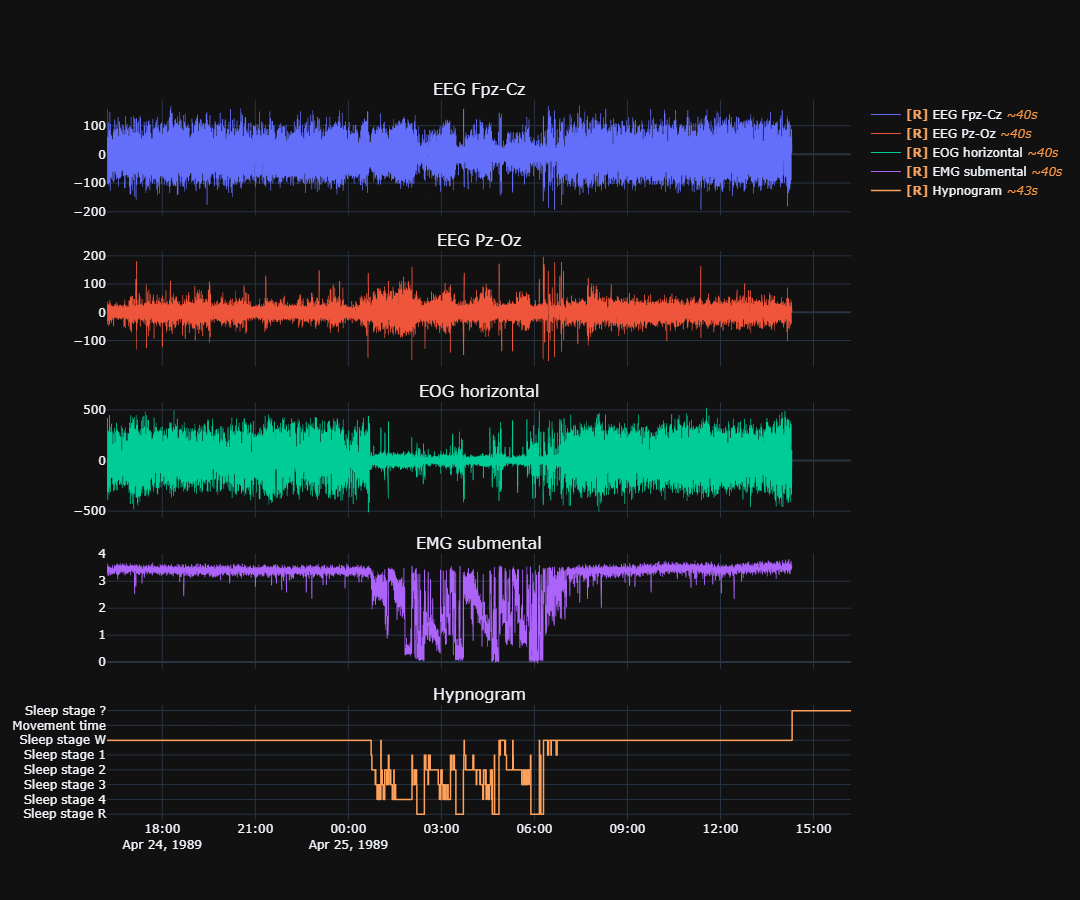

In [29]:
# Para ver el grafico generado sin tener que volver a correr todo el codigo descomentar estas lineas
# from IPython.display import Image, display
# image_path = './images/registro_polisonografico_1.png'
# display(Image(filename=image_path))

In [18]:
from scipy.signal import butter, lfilter
from tsflex.processing import SeriesPipeline, SeriesProcessor

def butter_bandpass_filter(sig, lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype="band")
    y = lfilter(b, a, sig)
    return y


# def clipper(sig, min_q=0, max_q=1):
#     return sig.clip(sig.quantile(min_q), sig.quantile(max_q))


eeg_bandpass = SeriesProcessor(
    function=butter_bandpass_filter,
    series_names=["EEG Fpz-Cz", "EEG Pz-Oz", "EOG horizontal"],
    lowcut=0.4,
    highcut=30,
    fs=100,
)

process_pipe = SeriesPipeline(
    [
        eeg_bandpass,
    ]
)

process_pipe

[
	butter_bandpass_filter {'lowcut': 0.4, 'highcut': 30, 'fs': 100} :  ('EEG Fpz-Cz',) ('EEG Pz-Oz',) ('EOG horizontal',)
]

In [19]:
%%time
data_processed = process_pipe.process(data, return_all_series=True)

INFO:feature_processing_logger:Finished function [butter_bandpass_filter] on [('EEG Fpz-Cz',), ('EEG Pz-Oz',), ('EOG horizontal',)] with output ['EEG Fpz-Cz', 'EEG Pz-Oz', 'EOG horizontal'] in [0.5209520029999339 seconds]!


CPU times: user 388 ms, sys: 126 ms, total: 514 ms
Wall time: 523 ms


In [ ]:
for s in data_processed:
    idx = idxs.index(s.name.split("_")[-1]) + 1
    fig.add_trace(
        go.Scatter(x=[], y=[], name=s.name + " processed", line_width=1),
        hf_x=s.index,
        hf_y=s.values,
        row=idx,
        col=1,
    )

fig.show_dash(port=8041)

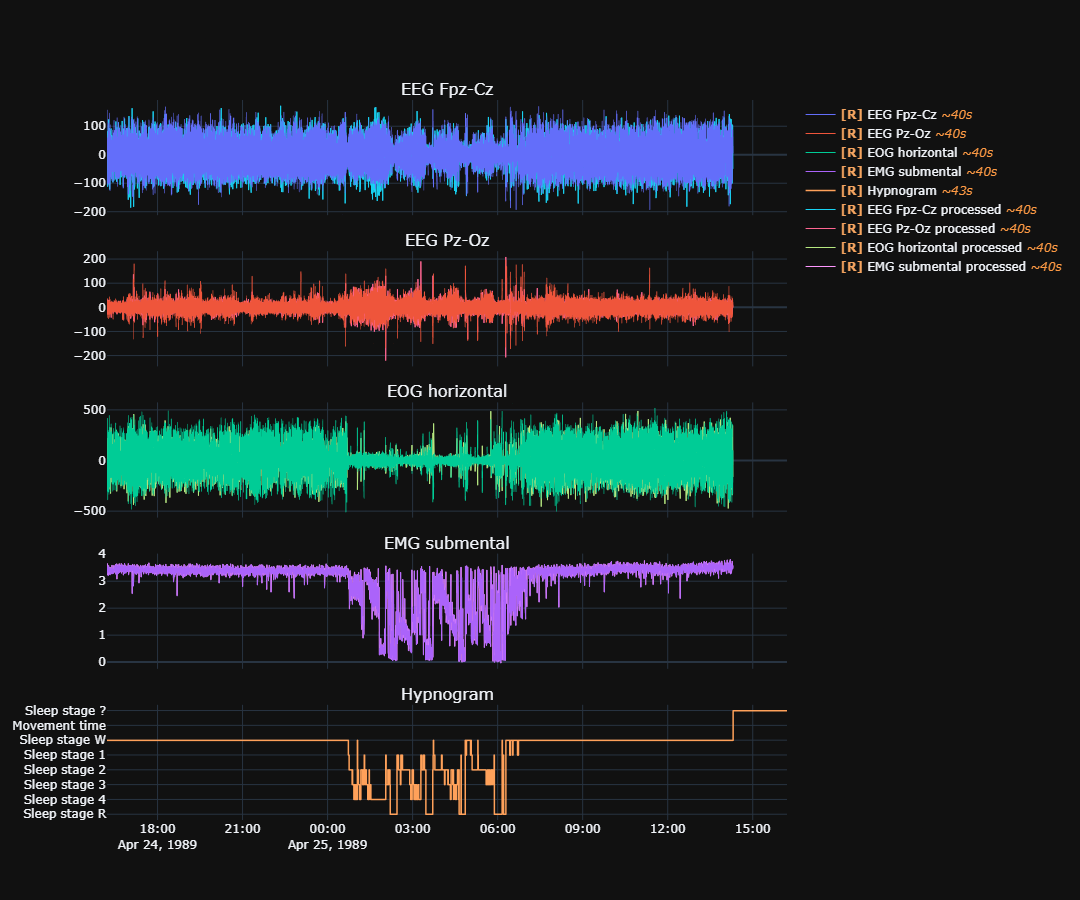

In [30]:
# Para ver el grafico generado sin tener que volver a correr todo el codigo descomentar estas lineas
# from IPython.display import Image, display
# image_path = './images/registro_polisonografico_2.png'
# display(Image(filename=image_path))

### Extraemos las features

In [21]:
# Create the collection of tsfresh features to extract

tsfresh_settings = {
    "fft_aggregated": [
        {"aggtype": "centroid"},
        {"aggtype": "variance"},
        {"aggtype": "skew"},
        {"aggtype": "kurtosis"},
    ],
    "fourier_entropy": [
        {"bins": 2},
        {"bins": 3},
        {"bins": 5},
        {"bins": 10},
        {"bins": 30},
        {"bins": 60},
        {"bins": 100},
    ],
    "binned_entropy": [
        {"max_bins": 5},
        {"max_bins": 10},
        {"max_bins": 30},
        {"max_bins": 60},
    ],
}

tsfresh_settings

{'fft_aggregated': [{'aggtype': 'centroid'},
  {'aggtype': 'variance'},
  {'aggtype': 'skew'},
  {'aggtype': 'kurtosis'}],
 'fourier_entropy': [{'bins': 2},
  {'bins': 3},
  {'bins': 5},
  {'bins': 10},
  {'bins': 30},
  {'bins': 60},
  {'bins': 100}],
 'binned_entropy': [{'max_bins': 5},
  {'max_bins': 10},
  {'max_bins': 30},
  {'max_bins': 60}]}

In [31]:
import antropy as ant
import scipy.stats as ss
from yasa import bandpower
import scipy.stats as ss
from tsflex.features import (
    FeatureCollection,
    FuncWrapper,
    MultipleFeatureDescriptors,
    FuncWrapper,
)
from tsflex.features.integrations import tsfresh_settings_wrapper


def wrapped_higuchi_fd(x):
    x = np.array(x, dtype="float64")
    return ant.higuchi_fd(x)


bands = [
    (0.4, 1, "sdelta"),
    (1, 4, "fdelta"),
    (4, 8, "theta"),
    (8, 12, "alpha"),
    (12, 16, "sigma"),
    (16, 30, "beta"),
]
bandpowers_ouputs = [b[2] for b in bands] + ["TotalAbsPow"]


def wrapped_bandpowers(x, sf, bands):
    return bandpower(x, sf=sf, bands=bands).values[0][:-2]


time_funcs = [
    np.std,
    ss.iqr,
    ss.skew,
    ss.kurtosis,
    ant.num_zerocross,
    FuncWrapper(
        ant.hjorth_params, output_names=["horth_mobility", "hjorth_complexity"]
    ),
    wrapped_higuchi_fd,
    ant.petrosian_fd,
    ant.perm_entropy,
] + tsfresh_settings_wrapper(tsfresh_settings)

freq_funcs = [
    FuncWrapper(wrapped_bandpowers, sf=100, bands=bands, output_names=bandpowers_ouputs)
]

time_feats = MultipleFeatureDescriptors(
    time_funcs,
    ["EEG Fpz-Cz", "EEG Pz-Oz", "EOG horizontal", "EMG submental"],
    windows=["30s", "60s", "90s"],
    strides="30s",
)
freq_feats = MultipleFeatureDescriptors(
    freq_funcs,
    ["EEG Fpz-Cz", "EEG Pz-Oz", "EOG horizontal"],
    windows=["30s", "60s", "90s"],
    strides="30s",
)

feature_collection = FeatureCollection([time_feats, freq_feats])

In [32]:
import logging

from tsflex.features.logger import logger
logger.setLevel(level=logging.ERROR)

from tsflex.processing.logger import logger
logger.setLevel(level=logging.ERROR)

feats = feature_collection.calculate(data_processed, return_df=True, show_progress=True)
feats.head()

  0%|          | 0/261 [00:00<?, ?it/s]

,EEG Fpz-Cz__TotalAbsPow__w=1m,EEG Fpz-Cz__TotalAbsPow__w=1m30s,EEG Fpz-Cz__TotalAbsPow__w=30s,EEG Fpz-Cz__alpha__w=1m,EEG Fpz-Cz__alpha__w=1m30s,EEG Fpz-Cz__alpha__w=30s,EEG Fpz-Cz__beta__w=1m,EEG Fpz-Cz__beta__w=1m30s,EEG Fpz-Cz__beta__w=30s,EEG Fpz-Cz__binned_entropy_{'max_bins': 10}__w=1m,...,EOG horizontal__skew__w=30s,EOG horizontal__std__w=1m,EOG horizontal__std__w=1m30s,EOG horizontal__std__w=30s,EOG horizontal__theta__w=1m,EOG horizontal__theta__w=1m30s,EOG horizontal__theta__w=30s,EOG horizontal__wrapped_higuchi_fd__w=1m,EOG horizontal__wrapped_higuchi_fd__w=1m30s,EOG horizontal__wrapped_higuchi_fd__w=30s
1989-04-24 16:13:30,NaN,NaN,552.556158,NaN,NaN,0.011966,NaN,NaN,0.01293,NaN,...,0.173134,NaN,NaN,71.403606,NaN,NaN,0.031219,NaN,NaN,1.257986
1989-04-24 16:14:00,410.013414,NaN,296.813297,0.018171,NaN,0.028862,0.024353,NaN,0.046444,1.667629,...,0.203721,73.886409,NaN,76.288450,0.042809,NaN,0.058202,1.488313,NaN,1.641231
1989-04-24 16:14:30,284.113885,347.419726,358.240748,0.032559,0.0239,0.032287,0.03873,0.027223,0.027552,1.564244,...,-0.279640,70.765891,70.979105,64.774158,0.032964,0.034947,0.025595,1.607514,1.512376,1.563791
1989-04-24 16:15:00,206.055516,230.349632,187.837507,0.056282,0.041142,0.074854,0.03516,0.036783,0.028251,1.431736,...,0.029593,47.508646,58.691484,17.845006,0.064335,0.044394,0.100081,1.660663,1.652097,1.830498
1989-04-24 16:15:30,177.742607,176.336873,173.517873,0.068842,0.063116,0.059463,0.027978,0.034582,0.027121,1.376963,...,-0.439511,16.211393,39.671042,14.390960,0.10672,0.089847,0.111054,1.828444,1.701058,1.827002


# Lista Resumida con Explicaciones

## Frecuencia Banda de Potencia (Frequency Band Power)

**Descripción**: Estas características miden la potencia dentro de bandas de frecuencia específicas (alpha, beta, delta, etc.) para diferentes longitudes de ventana.

**Ejemplos**:
- EEG Fpz-Cz__TotalAbsPow__w=X
- EEG Fpz-Cz__alpha__w=X
- EEG Fpz-Cz__beta__w=X
- EEG Fpz-Cz__fdelta__w=X
- EEG Fpz-Cz__sdelta__w=X
- EEG Fpz-Cz__theta__w=X
- EEG Pz-Oz__TotalAbsPow__w=X
- EEG Pz-Oz__alpha__w=X
- EEG Pz-Oz__beta__w=X
- EEG Pz-Oz__fdelta__w=X
- EEG Pz-Oz__sdelta__w=X
- EEG Pz-Oz__theta__w=X

## Medidas de Entropía (Entropy Measures)

**Descripción**: Las características de entropía capturan la complejidad o aleatoriedad en la señal.

**Ejemplos**:
- EEG Fpz-Cz__binned_entropy_{'max_bins': Y}__w=X
- EEG Fpz-Cz__fourier_entropy_{'bins': Y}__w=X
- EEG Fpz-Cz__perm_entropy__w=X
- EEG Pz-Oz__binned_entropy_{'max_bins': Y}__w=X
- EEG Pz-Oz__fourier_entropy_{'bins': Y}__w=X
- EEG Pz-Oz__perm_entropy__w=X
- EMG submental__binned_entropy_{'max_bins': Y}__w=X
- EMG submental__fourier_entropy_{'bins': Y}__w=X
- EMG submental__perm_entropy__w=X

## Características de Transformada de Frecuencia (Frequency Transform Features)

**Descripción**: Estas características se derivan de la transformada de Fourier, capturando varios momentos estadísticos y propiedades.

**Ejemplos**:
- EEG Fpz-Cz__fft_aggregated_{'aggtype': 'Z'}__w=X
- EEG Pz-Oz__fft_aggregated_{'aggtype': 'Z'}__w=X
- EMG submental__fft_aggregated_{'aggtype': 'Z'}__w=X

## Medidas Estadísticas (Statistical Measures)

**Descripción**: Son medidas estadísticas básicas como el rango intercuartil (IQR), curtosis, asimetría y desviación estándar.

**Ejemplos**:
- EEG Fpz-Cz__iqr__w=X
- EEG Fpz-Cz__kurtosis__w=X
- EEG Fpz-Cz__skew__w=X
- EEG Fpz-Cz__std__w=X
- EEG Pz-Oz__iqr__w=X
- EEG Pz-Oz__kurtosis__w=X
- EEG Pz-Oz__skew__w=X
- EEG Pz-Oz__std__w=X
- EMG submental__iqr__w=X
- EMG submental__kurtosis__w=X
- EMG submental__skew__w=X

## Parámetros de Hjorth (Hjorth Parameters)

**Descripción**: Los parámetros de Hjorth miden la complejidad y la movilidad de la señal, proporcionando información sobre las propiedades dinámicas de la serie temporal.

**Ejemplos**:
- EEG Fpz-Cz__hjorth_complexity__w=X
- EEG Fpz-Cz__hjorth_mobility__w=X
- EEG Pz-Oz__hjorth_complexity__w=X
- EEG Pz-Oz__hjorth_mobility__w=X
- EMG submental__hjorth_complexity__w=X
- EMG submental__hjorth_mobility__w=X

## Dimensión Fractal (Fractal Dimension)

**Descripción**: Las dimensiones fractales como Petrosian y Higuchi proporcionan medidas de la complejidad de la señal.

**Ejemplos**:
- EEG Fpz-Cz__petrosian_fd__w=X
- EEG Fpz-Cz__wrapped_higuchi_fd__w=X
- EEG Pz-Oz__petrosian_fd__w=X
- EEG Pz-Oz__wrapped_higuchi_fd__w=X
- EMG submental__petrosian_fd__w=X

## Cruces por Cero (Zero Crossings)

**Descripción**: Estas características cuentan el número de veces que la señal cruza el valor cero dentro de una ventana especificada.

**Ejemplos**:
- EEG Fpz-Cz__num_zerocross__w=X
- EEG Pz-Oz__num_zerocross__w=X
- EMG submental__num_zerocross__w=X

## Variables de Sustitución

- **X**: 1m, 1m30s, 30s (diferentes longitudes de ventana)
- **Y**: 2, 3, 5, 10, 30, 60, 100 (diferentes números de bins)
- **Z**: centroid, kurtosis, skew, variance (diferentes tipos de agregación)


In [ ]:
df = feats.copy()
fig = make_subplots(rows=2, cols=1, shared_xaxes=True, subplot_titles=('EEG Fpz-Cz', 'EEG Pz-Oz'))

# Grafico 1
fig.add_trace(go.Scatter(x=df.index, y=df['EEG Fpz-Cz__TotalAbsPow__w=1m'], mode='lines', name='TotalAbsPow__w=1m'), row=1, col=1)
fig.add_trace(go.Scatter(x=df.index, y=df['EEG Fpz-Cz__alpha__w=1m'], mode='lines', name='alpha__w=1m'), row=1, col=1)
fig.add_trace(go.Scatter(x=df.index, y=df['EEG Fpz-Cz__beta__w=1m'], mode='lines', name='beta__w=1m'), row=1, col=1)

# Grafico 2
fig.add_trace(go.Scatter(x=df.index, y=df['EEG Pz-Oz__TotalAbsPow__w=1m'], mode='lines', name='TotalAbsPow__w=1m'), row=2, col=1)

fig.update_layout(title='Gráficos de características EEG a lo largo del tiempo', height=900)
fig.show()

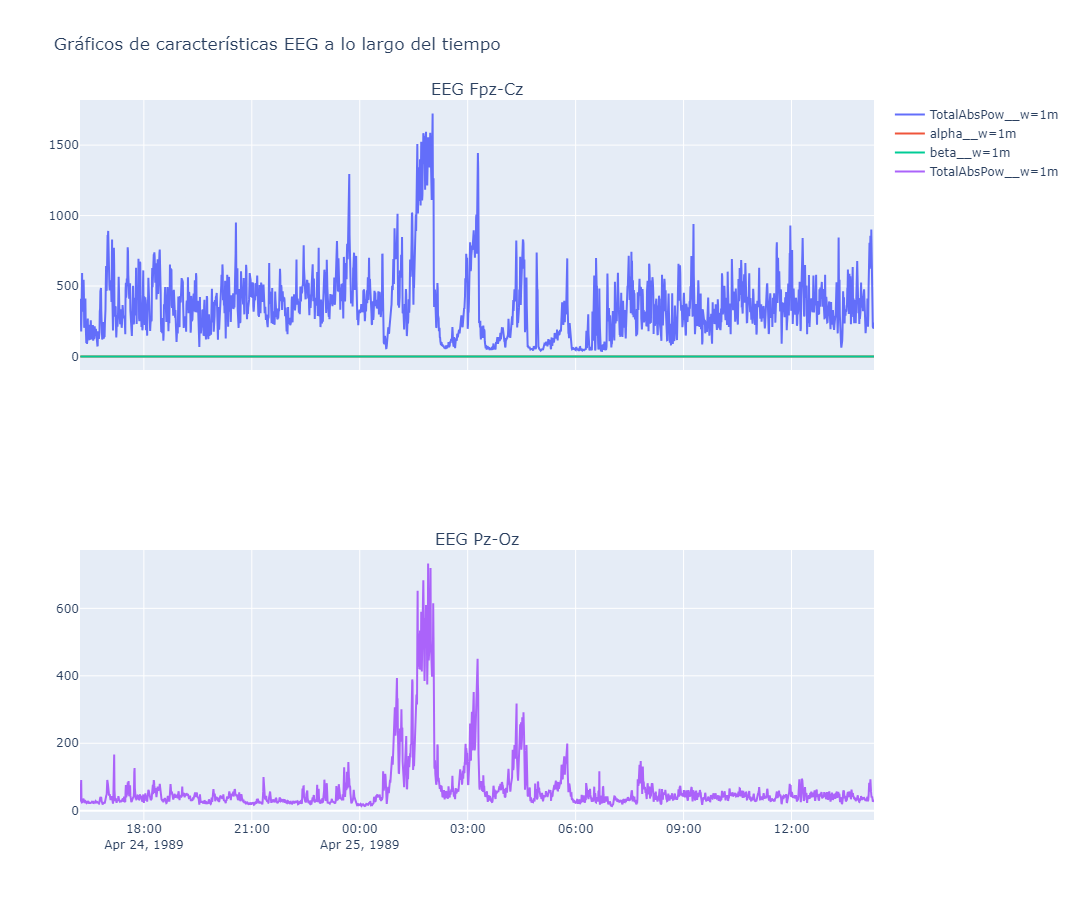

In [36]:
# Para ver el grafico generado sin tener que volver a correr todo el codigo descomentar estas lineas
# from IPython.display import Image, display
# image_path = './images/EEG_plot.png'
# display(Image(filename=image_path))